# IGA-03. Medical Appointments: The No-Show Problem

## Problem setup

An actual medical clinic in the USA has been facing financial losses for the third consecutive year. The problem is that patients are not showing up after getting the appointments in the first place. So, the clinic has been losing profits.
As one of the attempts to understand the situation, the authorities of the clinic decided to develop a model for predicting actual visits of patients based on their characteristics.

In this assignment you are asked to work with the **Decision Tree** and the **Random Forest** classifiers to try and develop such a model. You will also need to run a traditional cross-validation to check stability of the obtained results.

The dataset consists of **110 000+ records** on the patients of the clinic. Description of the variables is given in the  **medical_data.xlsx** file which contains the necessary information on the variables.

### Students
- Dodiya Indraraj
- Du Shaohui
- Magomedova Zamira
- Moiseeva Anastasiia

In [103]:
%matplotlib inline

# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from pydot import graph_from_dot_data
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score


In [2]:
# function to plot all features
def features_plots(discrete_vars):
    plt.figure(figsize=(15,24.5))
    
    # for continuous variables
    for i, cv in enumerate(['Age']):
        plt.subplot(7, 2, i+1)
        plt.hist(data[cv], bins=len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')
    
    # for discrete variables
    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+2)
        data[dv].value_counts().plot(kind='bar', title=dv)
        plt.ylabel('Frequency')

In [3]:
# function to estimate model performance

def model_performance(model_name, X_tr, y_tr, y_te, y_pred):
    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_te, y_pred))
    print('Test precision 0: %f'%metrics.precision_score(y_te, y_pred, pos_label=0))   
    print('Test precision 1: %f'%metrics.precision_score(y_te, y_pred, pos_label=1)) 
    print('Test recall 0: %f'%metrics.recall_score(y_te, y_pred, pos_label=0))   
    print('Test recall 1: %f'%metrics.recall_score(y_te, y_pred, pos_label=1))


## Task 0. Pre-processing the original data

**Study the steps taken here to pre-process the original data**.

In [4]:
# import the data 
data = pd.read_excel('medical_data.xlsx', sheet_name="data")

In [5]:
# look at the data
print(data.shape)
data.head(3)

(110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,Status
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [6]:
# print of the frequency of unique values of each feature
for column in list(data.columns):
    print("{0:25} {1}".format(column, data[column].nunique()))

PatientId                 62299
AppointmentID             110527
Gender                    2
ScheduledDay              103549
AppointmentDay            27
Age                       104
Neighbourhood             81
Scholarship               2
Hipertension              2
Diabetes                  2
Alcoholism                2
Handicap                  5
SMS_received              2
Status                    2


In [7]:
# make summary statistics
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


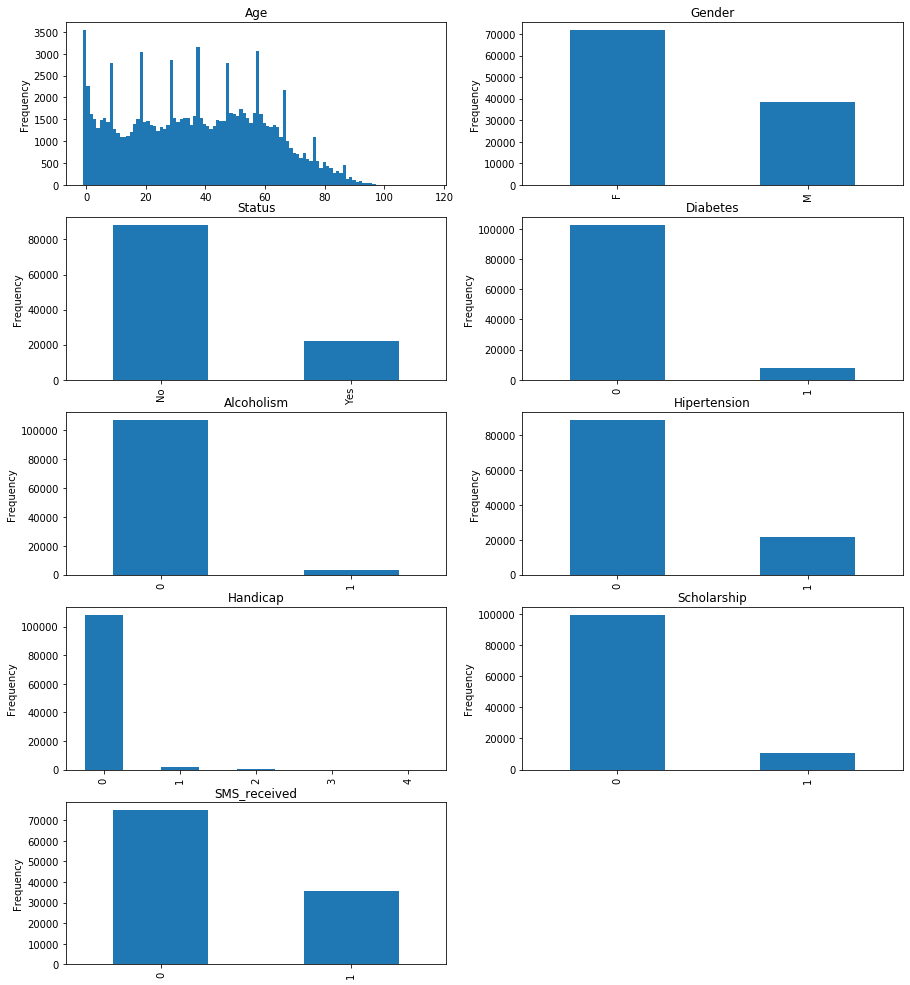

In [8]:
# make a list of discrete variables
discrete_vars = ['Gender', 'Status', 'Diabetes', 'Alcoholism', 'Hipertension', 'Handicap', 'Scholarship', 'SMS_received']

# construct graphs for features
features_plots(discrete_vars)


In [9]:
# remove unnecessary features
remove_vars=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood']
data.drop(remove_vars, inplace=True, axis=1)


In [10]:
# recode nominal variables
for field in ['Gender', 'Status']:
    data[field] = pd.Categorical(data[field]).codes

## Task 1 (1 point)

- As a result of the above-given descriptive analysis, which anomalies in the data have you detected? Name any two of them.
- Transform the dataset appropriately.
- Reconstruct the graphs of the discrete features.

- There is an anormal observation in the 'Age' variable: some woman is aged '-1'
- There is an observation in 'Handicap' variable = 4, which must not be correct

We dedided to drop those observations from the dataset. 

In [33]:
# introduce transformations of the dataset here
# we decided to drop the rows where handicap and age are equal to the values specified below 
data.drop( data[ data['Handicap'] == 4 ].index , inplace=True)
data.drop( data[ data['Handicap'] == 3 ].index , inplace=True)
data.drop( data[ data['Handicap'] == 2 ].index , inplace=True)
data.drop( data[ data['Age'] == -1 ].index , inplace=True)

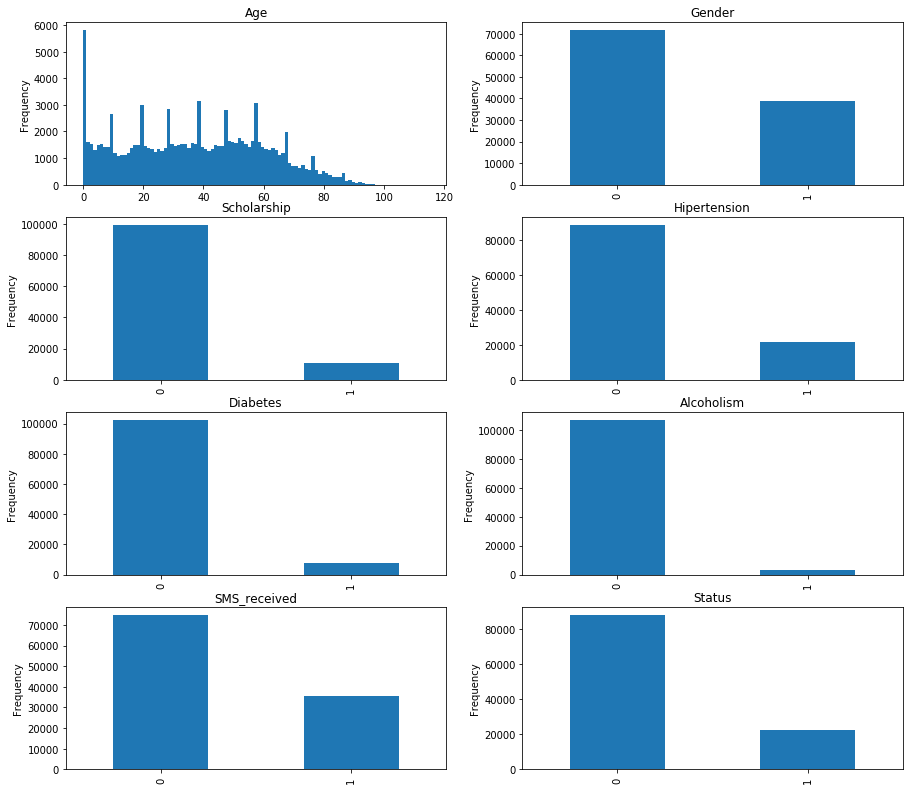

In [34]:
# check the results
discrete_vars2 = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received', 'Status']

# constructing graphs for features
features_plots(discrete_vars2)

### Preparing for calculations

In [20]:
# make X and y
y = data['Status']

X = data.copy()
X.drop(["Status"], axis=1, inplace=True)

In [95]:
# make a fixed split into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)

## Task 2 (1 point)

- Work with the obtained split on the training and the test samples, and estimate a **Decision Tree** classifier with the **default parameters**.
- Estimate its performance using the model_performance function.
- Briefly comment on the results.

In [96]:
# define the DT-classifier
clfr_DT = DTC(criterion='gini', max_depth=None, random_state=0)

# estimate the DT-model

clfr_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [102]:
# check performance of the DT-model
y_predict = clfr_DT.predict(X_test)

# estimate the RF-model
model_performance(clfr_DT, X_train, y_train, y_test, y_predict)


Model name: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Test accuracy (Accuracy Score): 0.797471
Test precision 0: 0.801153
Test precision 1: 0.414286
Test recall 0: 0.993024
Test recall 1: 0.019626


**Give your comments here**

We can see that recalls are not equal, not even close to equal, so the classes are not predicred proportionately equally. Accuracy itself is very low.

## Task 3 (1 point)

- Work with the obtained split on the training and the test samples, and estimate a **Random Forest** classifier for 200 trees.
- Estimate its performance using the **model_performance** function.
- Compare the results of performance of the RF-model with the DT-model. Briefly comment.

In [79]:
# define the RF-classifier
clfr_RF = RFC(n_estimators=200).fit(X_train, y_train.values.ravel())

In [85]:
# check performance of the RF-model
# check performance of the RF-model
y_predict_RF = clfr_RF.predict(X_test)
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_predict_RF))
print(metrics.classification_report(y_true=y_test, y_pred=y_predict_RF))
# estimate the RF-model
model_performance(clfr_RF,X_train,y_train,y_test,y_predict_RF)

[[17487   146]
 [ 4337    96]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17633
           1       0.40      0.02      0.04      4433

    accuracy                           0.80     22066
   macro avg       0.60      0.51      0.46     22066
weighted avg       0.72      0.80      0.72     22066

Model name: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Test accuracy (Accuracy Score): 0.796837
Test precision 0: 0.801274
Test precision 1: 0.396694
Test recall 0: 0.991720
Test recall 1: 0.021

Accuracy didn't change, but the recall for class 1 increased a little bit, and precision dropped. 

## Task 4 (1 point)

- Using the **cross_validate** function, run a 10-fold cross-validation for the Decision Tree classifier for the **F1** metric.
- Print out the results of the cross-validation.


In [105]:
# cross-validation for Decision Tree
cv_results = cross_validate(clfr_RF, X_test, y_test, cv=10)

In [ ]:
# F1: results for DT


## Task 5 (1 point)

- Comment on the obtained performance results of the both classifiers. Specify **any two** peculiarities.
- What would you suggest to do to improve performance of the classifiers? Give **one specific** suggestion.

We would suggest balancing the dataset because it is very imbalanced. 

